In [1]:
GC_WINDOW_SIZE = 1000000

# experiments/germline-model/chen-et-al-2022/compare-mchale-and-chen-windows.ipynb
# experiments/germline-model/chen-et-al-2022/null-distribution-is-normal.ipynb
# experiments/germline-model/chen-et-al-2022/QQ-plot-for-noncoding-windows.ipynb

## Non-exonic windows, with Gnocchi and various features (e.g. GC content), and enhancer-overlap status 

In [2]:
from get_windows import get_windows_with_GC_content_and_cpg_islands 

WINDOWS = get_windows_with_GC_content_and_cpg_islands()
WINDOWS 

,chrom,start,end,gnocchi,N_observed,window overlaps enhancer,window overlaps merged_exon,B,paternal_recombination_rate,maternal_recombination_rate,...,B1_M3starHMT6.EUR,Bmean_M3starHMT6.EUR,lambda_M3starHMT6.EUR,GC_content_1000bp,GC_content_10000bp,GC_content_100000bp,GC_content_1000000bp,cpg_island_overlap,window_overlaps_cpg_island,N_mean_null_gnocchi
0,chr1,1432000,1433000,4.299894,259,True,False,0.653,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.661339,0.641836,0.565094,0.577534,NaN,False,338.059552
1,chr1,1451000,1452000,0.666316,291,False,False,0.652,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.556444,0.552845,0.572894,0.575506,NaN,False,302.590657
2,chr1,1453000,1454000,0.828398,256,False,False,0.651,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.537463,0.561944,0.572564,0.575129,NaN,False,269.601925
3,chr1,1458000,1459000,-0.086128,272,False,False,0.651,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.532468,0.596740,0.570774,0.575225,NaN,False,270.583243
4,chr1,1463000,1464000,2.948188,191,True,False,0.651,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.540460,0.568843,0.576514,0.574420,NaN,False,236.321790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019146,chr9,137262000,137263000,-2.396149,302,True,False,0.536,0.057053,0.063434,...,3.636507,0.219258,2.281162,0.500499,0.542646,0.611944,0.568316,45.0,True,263.131293
1019147,chr9,137268000,137269000,3.640544,212,True,False,0.536,0.057053,0.063434,...,3.636507,0.219258,2.281162,0.552448,0.589941,0.613074,0.567839,NaN,False,272.046527
1019148,chr9,137269000,137270000,5.276351,209,True,False,0.536,0.057053,0.063434,...,3.636507,0.219258,2.281162,0.519481,0.585042,0.613494,0.567623,NaN,False,300.458958
1019149,chr9,137275000,137276000,2.687348,290,True,False,0.536,1.564889,0.024254,...,3.636507,0.219258,2.281162,0.603397,0.639236,0.610484,0.567380,NaN,False,339.517045


## GC content, gBGC and BGS are correlated 


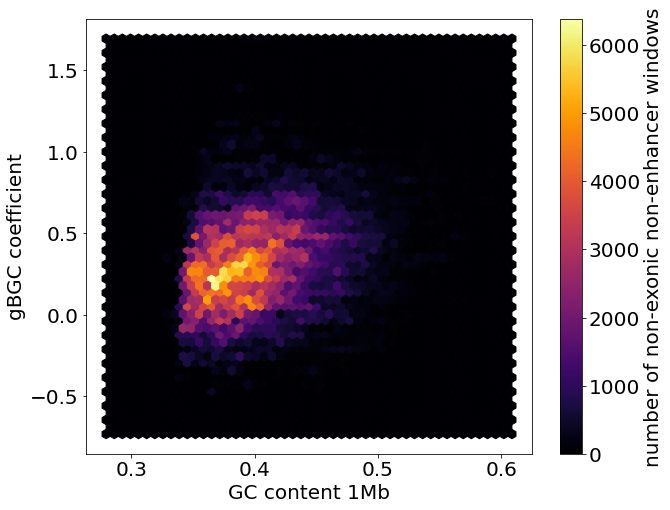

In [3]:
import matplotlib.pyplot as plt 
plt.rcParams.update({
    'font.size': 20,
    'figure.figsize': (12, 6)
})

from util import length_to_string

def window_count_heat_map(df, x, y, xlabel, ylabel, min_windows=0):
  plt.figure(figsize=(10, 8))  

  plt.hexbin(
    df[x], 
    df[y], 
    gridsize=50, 
    cmap='inferno',
    mincnt=min_windows  # Minimum number of windows required for a hexbin to be displayed
  )

  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.colorbar(label='number of non-exonic non-enhancer windows')

window_count_heat_map(
  WINDOWS, 
  x=f'GC_content_{GC_WINDOW_SIZE}bp', 
  y='B_M1star.EUR', 
  xlabel=f'GC content {length_to_string(GC_WINDOW_SIZE)}', 
  ylabel='gBGC coefficient'
)

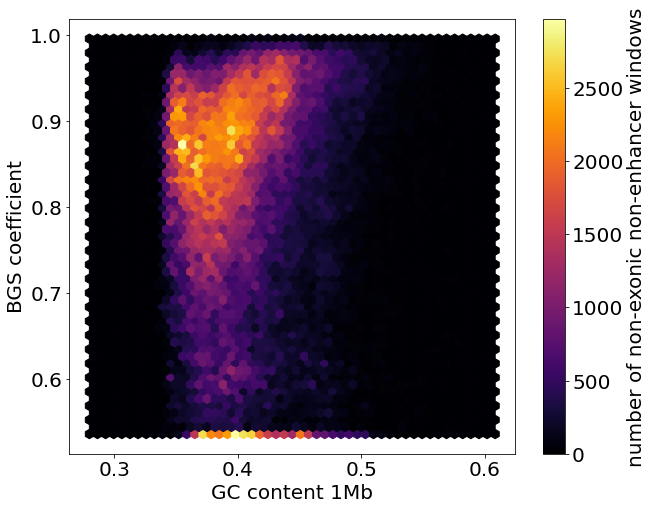

In [4]:
window_count_heat_map(
  WINDOWS, 
  x=f'GC_content_{GC_WINDOW_SIZE}bp', 
  y='B', 
  xlabel=f'GC content {length_to_string(GC_WINDOW_SIZE)}', 
  ylabel='BGS coefficient'
)

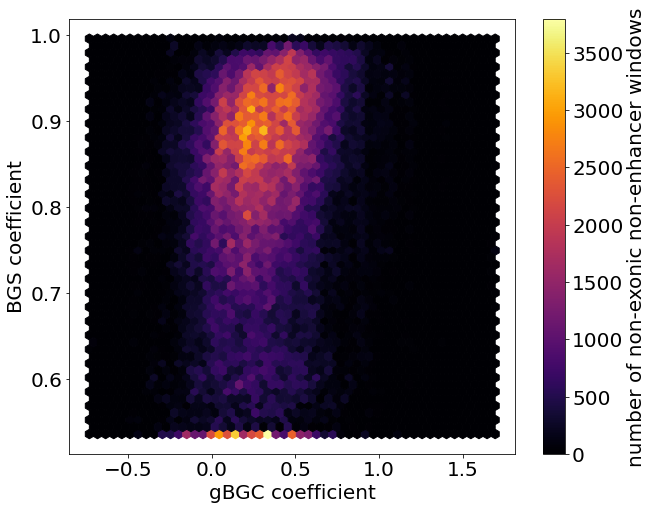

In [5]:
window_count_heat_map(
  WINDOWS, 
  x='B_M1star.EUR', 
  y='B', 
  xlabel='gBGC coefficient', 
  ylabel='BGS coefficient'
)

## XXX

In [12]:
import matplotlib.pyplot as plt 
plt.rcParams.update({
    'font.size': 20,
    'figure.figsize': (12, 6)
})

from scipy.stats import norm
import pandas as pd 

def compute_zscores_of_features(df): 
    df = df.copy()
    features = [ 
        f'GC_content_{gc_window_size}bp' 
        for gc_window_size in [1000, 10000, 100000, 1000000]
    ]
    features += ['B_M1star.EUR', 'B']

    zscore_features = [f'zscore_{feature}' for feature in features]

    for feature, zscore_feature in zip(features, zscore_features):
        df[zscore_feature] = (df[feature] - df[feature].mean())/df[feature].std()

    return df[['gnocchi'] + features + zscore_features]

compute_zscores_of_features(WINDOWS)

,gnocchi,GC_content_1000bp,GC_content_10000bp,GC_content_100000bp,GC_content_1000000bp,B_M1star.EUR,B,zscore_GC_content_1000bp,zscore_GC_content_10000bp,zscore_GC_content_100000bp,zscore_GC_content_1000000bp,zscore_B_M1star.EUR,zscore_B
0,4.299894,0.661339,0.641836,0.565094,0.577534,0.108103,0.653,4.200591,4.846192,3.624139,4.300488,-0.772320,-1.343476
1,0.666316,0.556444,0.552845,0.572894,0.575506,0.108103,0.652,2.488799,3.041662,3.798498,4.250476,-0.772320,-1.351749
2,0.828398,0.537463,0.561944,0.572564,0.575129,0.108103,0.651,2.179046,3.226168,3.791121,4.241179,-0.772320,-1.360023
3,-0.086128,0.532468,0.596740,0.570774,0.575225,0.108103,0.651,2.097532,3.931750,3.751108,4.243547,-0.772320,-1.360023
4,2.948188,0.540460,0.568843,0.576514,0.574420,0.108103,0.651,2.227954,3.366064,3.879418,4.223695,-0.772320,-1.360023
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019146,-2.396149,0.500499,0.542646,0.611944,0.568316,0.165515,0.536,1.575827,2.834850,4.671409,4.073167,-0.555422,-2.311504
1019147,3.640544,0.552448,0.589941,0.613074,0.567839,0.165515,0.536,2.423588,3.793882,4.696669,4.061404,-0.555422,-2.311504
1019148,5.276351,0.519481,0.585042,0.613494,0.567623,0.165515,0.536,1.885596,3.694542,4.706058,4.056077,-0.555422,-2.311504
1019149,2.687348,0.603397,0.639236,0.610484,0.567380,0.165515,0.536,3.255030,4.793470,4.638773,4.050085,-0.555422,-2.311504


number of windows: 148541


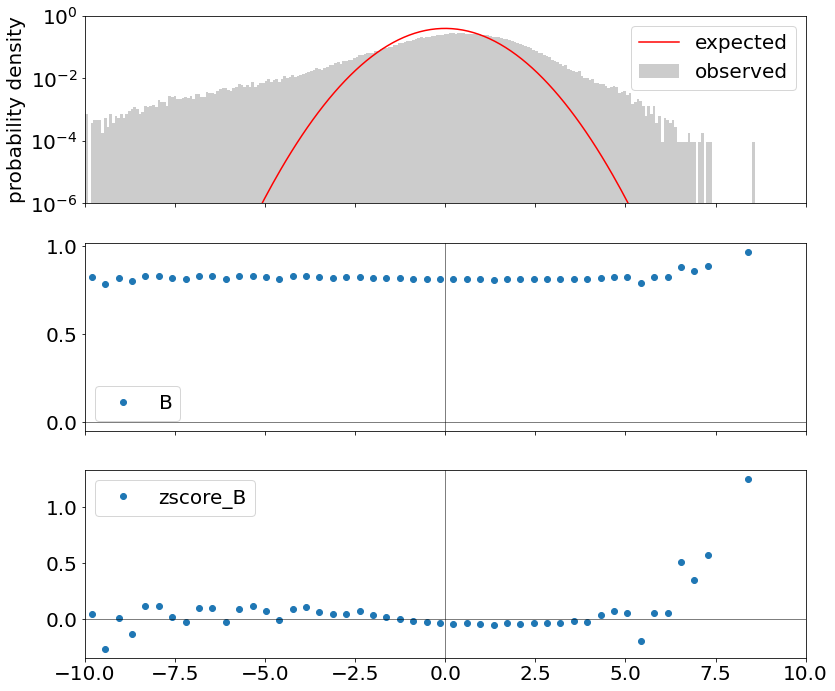

number of windows: 130932


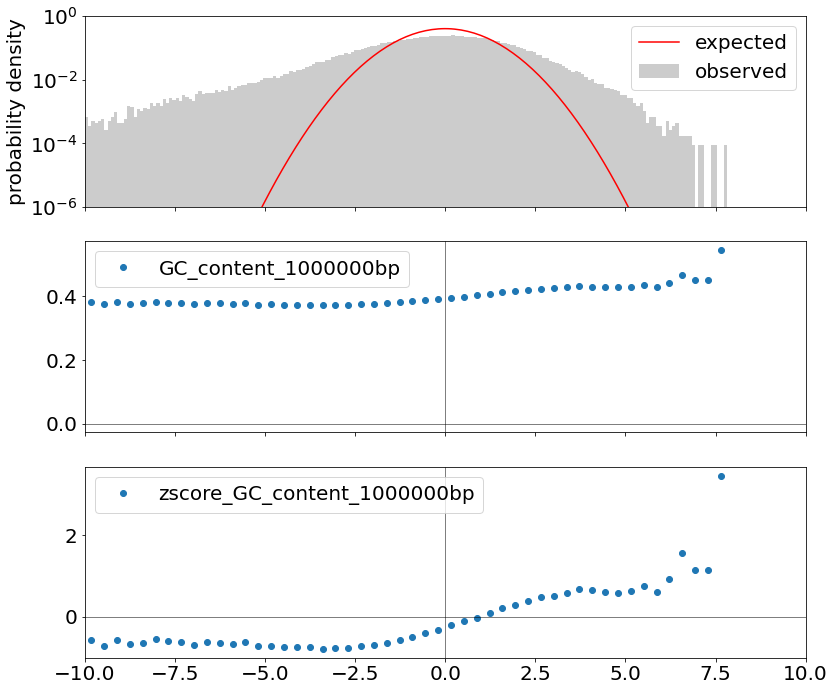

number of windows: 125992


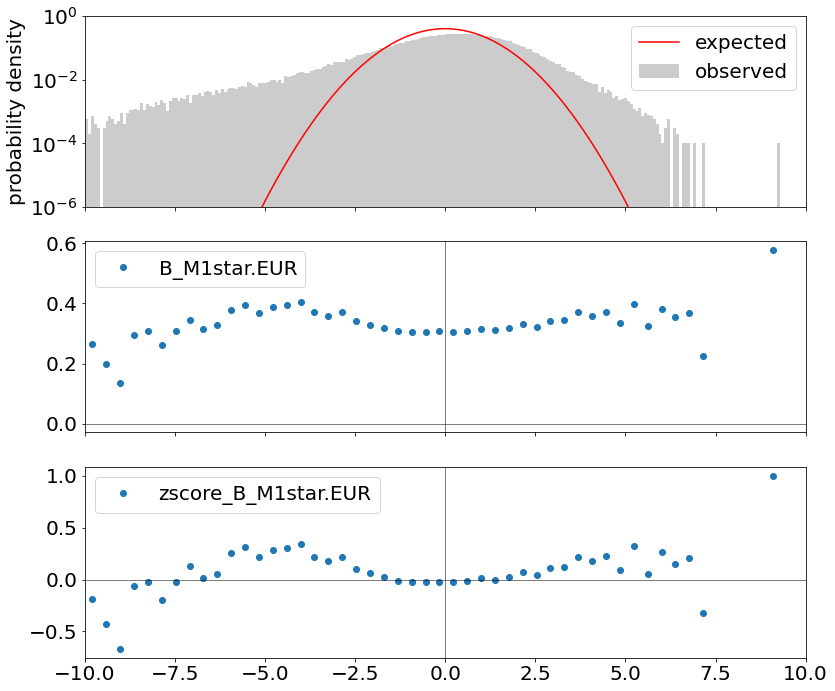

In [23]:
import numpy as np 

def slice_feature_space(df, conditional_features): 
    zlim = 0.5*np.array([-1, 1])
    for conditional_feature in conditional_features: 
        df = df[
            (df[conditional_feature] > zlim[0]) & 
            (df[conditional_feature] < zlim[1])
        ]
    return df 

def plot_feature_vs_gnocchi(df, feature, label, ax):
    df['gnocchi_binned'] = pd.cut(df['gnocchi'], bins=50)
    df_aggregated = df.groupby('gnocchi_binned')[feature].mean()
    df_aggregated.index = df_aggregated.index.map(lambda x: x.mid)
    ax.plot(df_aggregated.index, df_aggregated, marker='o', linestyle='', label=label)

def plot_distribution_of_gnocchi_and_feature_zscore(df, feature, conditional_features): 
    df = compute_zscores_of_features(df)
    df = slice_feature_space(df, conditional_features)    
    print(f'number of windows: {len(df)}')
    
    fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    _, bins, _ = axs[0].hist(
        df['gnocchi'], 
        density=True, 
        bins='auto', 
        histtype='stepfilled', 
        alpha=0.2, 
        label='observed', 
        color='black'
    )
    axs[0].plot(bins, norm.pdf(bins), label='expected', color='red')
    axs[0].set_ylabel('probability density')
    axs[0].set_xlim([-10, 10])
    axs[0].set_yscale('log')
    axs[0].set_ylim([1e-6, 1])
    axs[0].legend()

    plot_feature_vs_gnocchi(
        df, 
        feature,
        label=feature, 
        ax=axs[1]
    )
    axs[1].axhline(0, color='black', linewidth=0.5)
    axs[1].axvline(0, color='black', linewidth=0.5)        
    # axs[1].set_ylabel(feature)
    axs[1].legend()

    plot_feature_vs_gnocchi(
        df, 
        f'zscore_{feature}',
        label=f'zscore_{feature}', 
        ax=axs[2]
    )
    axs[2].axhline(0, color='black', linewidth=0.5)
    axs[2].axvline(0, color='black', linewidth=0.5)        
    # axs[2].set_ylabel(f'zscore_{feature}')
    axs[2].legend()

    plt.tight_layout()
    plt.show()

plot_distribution_of_gnocchi_and_feature_zscore(
    WINDOWS,
    feature='B',
    conditional_features=['zscore_GC_content_1000000bp', 'zscore_B_M1star.EUR']
)

plot_distribution_of_gnocchi_and_feature_zscore(
    WINDOWS,
    feature='GC_content_1000000bp',
    conditional_features=['zscore_B', 'zscore_B_M1star.EUR']
)

plot_distribution_of_gnocchi_and_feature_zscore(
    WINDOWS,
    feature='B_M1star.EUR',
    conditional_features=['zscore_B', 'zscore_GC_content_1000000bp']
)

In [8]:
# TODO: plot distribution of GC content, gBGC, BGS and confirm that they are approx normal 

# TODO: change title above 

# TODO: MONDAY 
# To disentangle these, and determine the direct effect each has on model bias (frac_below_diag), 
# we computed bias in 3D cubes, and intersected planes in feature space, yielding lines along which we plot bias. 
# The results show that bias is strongest along the GC-content line, and much weaker along the gBGC and BGS lines. 
# [Comparing bias is better than comparing zscores of features, which is what we are doing above] 
# [Also, my bias heat maps suggest that it will be easy to get widely different biases for the three scenarios]